In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import segyio
from scipy import fftpack

In [3]:
from ukpgks import segy
from ukpgks import plots
from ukpgks import signal

In [5]:
data,hdr = segy.read_segy('48_obs_50km.segy') # seimic data
spec,_= segy.read_segy('48_obs_50km_fk.segy') # fk spectrum calc by seismic software
data.shape,spec.shape

((500, 2500), (500, 1251))

Text(0.5, 11.0, 'Wavenumber')

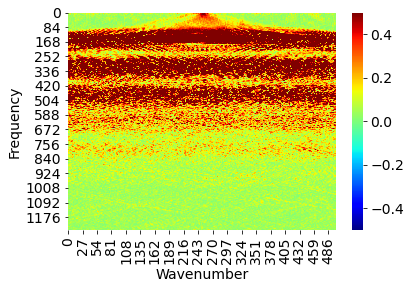

In [17]:
# fk spectrum calc by seismic software to QC
fig,ax = plt.subplots()
ax = sns.heatmap (spec.T,cmap='jet',vmin=-0.5,vmax=0.5)
ax.set_ylabel('Frequency')
ax.set_xlabel('Wavenumber')

(2500, 500)

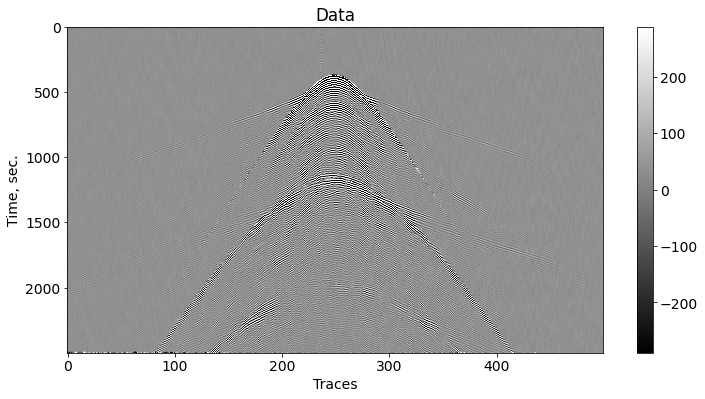

In [7]:
plots.plot2D_shot(data)
d = data.T
d.shape

50.0

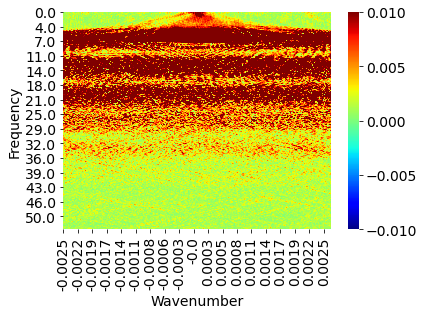

In [49]:
s,freqs,kx = signal.fk_transform(d,0.01,200,norm='minmax')
fig,ax = plt.subplots()
sns.heatmap (s,cmap='jet',vmin=-0.01,vmax=0.01,)
ax.set_ylabel('Frequency')
ax.set_xlabel('Wavenumber')
ax.set_xticklabels(np.linspace(kx.min(),kx.max(),19,endpoint=True).round(4))
ax.set_yticklabels(np.linspace(freqs.min(),freqs.max(),15,endpoint=True).round(0))
freqs.max()

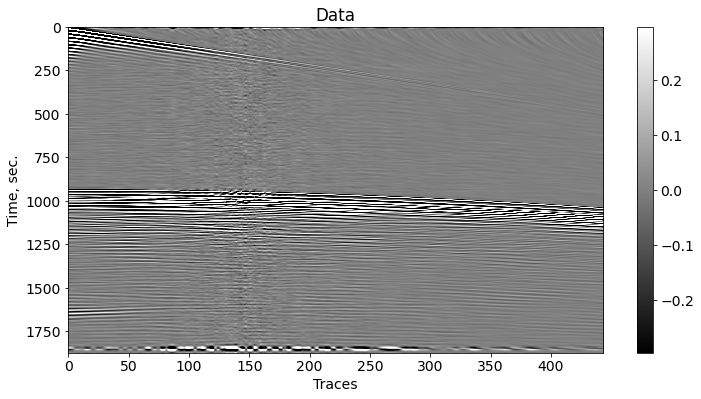

In [60]:
d,hdr = segy.read_segy('ffid_1000_mcs.segy')
plots.plot2D_shot(d)

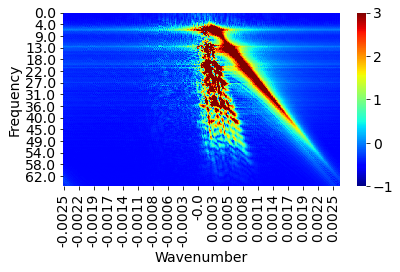

In [57]:
d,hdr = segy.read_segy('ffid_1000_mcs.segy')
fig,ax = plt.subplots()
ss,freqs,wavenum = signal.fk_transform(d.T,0.008,12.5,norm='std')
sns.heatmap (ss,cmap='jet',vmin=-1,vmax=3)
ax.set_ylabel('Frequency')
ax.set_xlabel('Wavenumber')
ax.set_xticklabels(np.linspace(kx.min(),kx.max(),19,endpoint=True).round(4))
ax.set_yticklabels(np.linspace(freqs.min(),freqs.max(),15,endpoint=True).round(0))
plt.tight_layout()

In [21]:
def fk_transform(data,dt,dx,norm='std',kind='np',ishift=1):
    """
    Uses built in np.fft (type='np')  or scipy.fftpack(type='scipy') to perform
    a 2-d f-k transform on a real valued (seismic time-space) matrix.
    Only the positive frequencies are calculated while all kxs are.
    Input traces should be regularly spaced.  Output traces are real-valued and
    represent the magnitude of the complex F-K spectrum.
    
    input:
    data[time,traces]    -seismic data
    dt,dx                -sampling rate alon time and trace axes
    norm['std','minmax',None] -scale
    
    output:
    spec -2D spectrum,freq-vector, kx-vector
    """
    nt,ntr = data.shape[0],data.shape[1]

    if kind == 'np':
        # returns only the positive freq, the t-f transform each
        # each column (or each traces) of the matrix is transformed
        spec_fx  = np.fft.rfft(data,axis=0)
        freq     = np.fft.rfftfreq(nt,dt)          # vector of frequency coordinates for the rows of spec
        spec     = np.fft.ifft(spec_fx.T,axis=0).T # 1D fft along time axis or along rows
    elif kind =='scipy':
        spec_fx  = fftpack.rfft(data,axis=0)
        freq     = np.fft.rfftfreq(nt,dt)
        spec     = fftpack.ifft(spec_fx.T,axis=0).T


    kxnyg    = 1 / (2*dx)
    dkx    = 2 * kxnyg/spec.shape[1]

    kx1 = np.arange(0,kxnyg,dkx)         # wavenumbers posit
    kx2 = np.arange(-kxnyg,-dkx+dkx,dkx) # wavenumbers negat
    kx1 = np.hstack((kx1,kx2))
    ikx = np.argsort(kx1)
    kx  = np.sort(kx1)

    if ishift == 1:
        spec      = spec[:,ikx]

    if norm == None:
        spec = abs(spec)
    elif norm == 'std':
        spec = abs(spec)
        spec = (spec - np.mean(spec)) / np.std(spec)
    elif norm =='minmax':
        a,b = 0,1
        spec = abs(spec)
        spec = (b-a) * ( (spec-np.min(spec)) / (np.max(spec) - np.min(spec)) ) + a

    return spec,freq, kx     